# Use of PYBIND11_MAKE_OPAQUE

[pybind11](https://pybind11.readthedocs.io/) automatically converts `std::vector` into python list. That's convenient but not necessarily efficient depending on how it is used after that. [PYBIND11_MAKE_OPAQUE](https://pybind11.readthedocs.io/en/stable/advanced/cast/stl.html#making-opaque-types) is used to create a [capsule](https://docs.python.org/3/c-api/capsule.html) to hold a pointer on the C++ object.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Two identical classes

Both of then creates random vectors equivalent to `std::vector<Tensor>`, and `Tensor ~  std::vector<float>`. The first one returns a capsule due `PYBIND11_MAKE_OPAQUE(std::vector<OneTensorFloat>)` inserted into the C++ code. The other one is returning a list.

In [3]:
from cpyquickhelper.examples.vector_container_python import (
    RandomTensorVectorFloat, RandomTensorVectorFloat2)

rnd = RandomTensorVectorFloat(10, 10)
result = rnd.get_tensor_vector()
print(result)

In [4]:
rnd2 = RandomTensorVectorFloat2(10, 10)
result2 = rnd2.get_tensor_vector()
print(result2)

[<cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000001859CF39170>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000001859CF39F70>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000001859CF39BB0>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x00000185AD0FEB30>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x00000185AD0FE5B0>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000001859BDC7A30>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x00000185AD12C270>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000001859CF08BB0>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000001859CF08670>, <cpyquickhelper.examples.vector_container_python.OneTensor2 object at 0x000001859CF08530>]


In [5]:
%timeit rnd.get_tensor_vector()

3.32 µs ± 251 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [6]:
%timeit rnd2.get_tensor_vector()

8.28 µs ± 603 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Plots

In [7]:
import itertools
from cpyquickhelper.numbers.speed_measure import measure_time
from tqdm import tqdm
import pandas

data = []
sizes = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 5000, 10000]
sizes = list(itertools.product(sizes, sizes))
for i, j in tqdm(sizes):
    if j >= 1000:
        if i > 1000:
            continue
    if i * j >= 1e6:
        repeat, number = 3, 3
    else:
        repeat, number = 10, 10
    rnd = RandomTensorVectorFloat(i, j)
    obs = measure_time(lambda: rnd.get_tensor_vector(), repeat=repeat, number=number, div_by_number=True)
    obs['name'] = 'capsule'
    obs['n_vectors'] = i
    obs['size'] = j
    data.append(obs)

    rnd2 = RandomTensorVectorFloat2(i, j)
    obs = measure_time(lambda: rnd2.get_tensor_vector(), repeat=repeat, number=number, div_by_number=True)
    obs['name'] = 'list'
    obs['n_vectors'] = i
    obs['size'] = j
    data.append(obs)
    
df = pandas.DataFrame(data)
df.tail()

100%|██████████| 144/144 [00:17<00:00,  8.40it/s]


,average,deviation,min_exec,max_exec,repeat,number,ttime,context_size,name,n_vectors,size
271,0.013293,0.000626,0.012571,0.014098,3,3,0.039880,64,list,10000,100
272,0.004341,0.000290,0.003966,0.004672,3,3,0.013023,64,capsule,10000,200
273,0.017498,0.000156,0.017283,0.017649,3,3,0.052493,64,list,10000,200
274,0.011086,0.000288,0.010679,0.011306,3,3,0.033258,64,capsule,10000,500
275,0.034558,0.001120,0.033475,0.036101,3,3,0.103675,64,list,10000,500


In [8]:
piv = pandas.pivot_table(df, index=['n_vectors', 'size'], columns=['name'], values='average')
piv['ratio'] = piv['capsule'] / piv['list']
piv.tail()

name             capsule      list     ratio
n_vectors size                              
10000     20    0.001613  0.008730  0.184796
          50    0.001738  0.009475  0.183459
          100   0.002154  0.013293  0.162071
          200   0.004341  0.017498  0.248090
          500   0.011086  0.034558  0.320787

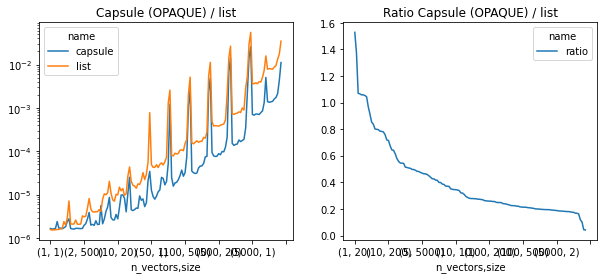

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
piv[['capsule', 'list']].plot(logy=True, ax=ax[0], title='Capsule (OPAQUE) / list')
piv.sort_values('ratio', ascending=False)[['ratio']].plot(ax=ax[1], title='Ratio Capsule (OPAQUE) / list');

In [10]:
flat = piv.reset_index(drop=False)[['n_vectors', 'size', 'ratio']]
flat_piv = flat.pivot('n_vectors', 'size', 'ratio')
flat_piv

size,1,2,5,10,20,50,100,200,500,1000,5000,10000
n_vectors,,,,,,,,,,,,
1,1.057898,1.052903,1.057915,1.069532,1.528040,1.065461,1.043849,0.967817,0.718879,0.913452,0.837577,0.386794
2,0.783155,0.778883,0.757703,0.643482,0.801230,0.798571,0.784203,0.514042,0.641503,0.674729,0.557646,0.481368
5,0.425734,0.511662,0.496383,0.614674,0.505612,0.458852,1.371857,0.272900,0.262494,0.415521,0.468828,0.427188
10,0.278069,0.347304,0.371056,0.344596,0.280381,0.338371,0.796157,0.714684,0.852634,0.383743,0.398465,0.579364
20,0.221000,0.260713,0.286421,0.350758,0.273275,0.545244,0.345398,0.247667,0.238862,0.220992,0.369198,0.044507
50,0.255547,0.212783,0.184586,0.188693,0.276636,0.257769,0.463637,0.490660,0.293864,0.276708,0.041333,0.474217
100,0.309091,0.201120,0.206130,0.224142,0.247696,0.259260,0.342168,0.258849,0.213695,0.399097,0.542843,0.507687
200,0.224348,0.216018,0.190418,0.180585,0.255936,0.269096,0.271124,0.249855,0.371308,0.277920,0.449509,0.438253
500,0.195512,0.205062,0.195034,0.199716,0.232794,0.209011,0.239958,0.229105,0.236154,0.101100,0.482890,0.543646


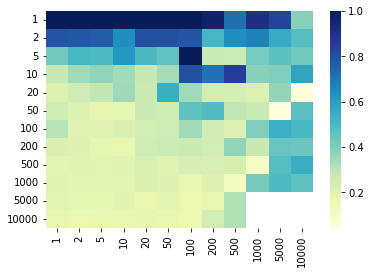

In [11]:
import numpy
import seaborn
seaborn.heatmap(numpy.minimum(flat_piv.values, 1), cmap="YlGnBu",
                xticklabels=list(flat_piv.index), yticklabels=list(flat_piv.columns));